# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

# 1. Is the distribution of body temperatures normal?

In [3]:
print(df.head())
print(df.info())

   temperature gender  heart_rate
0         99.3      F        68.0
1         98.4      F        81.0
2         97.8      M        73.0
3         99.2      F        66.0
4         98.0      F        73.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB
None


In [6]:
print(df.gender.unique())
print('Minimum Temperature: ', str(min(df.temperature)))
print('Maximum Temperature: ', str(max(df.temperature)))
print('Minimum Heart rate: ', str(min(df.heart_rate)))
print('Maximum Heart rate: ', str(max(df.heart_rate)))

['F' 'M']
Minimum Temperature:  96.3
Maximum Temperature:  100.8
Minimum Heart rate:  57.0
Maximum Heart rate:  89.0


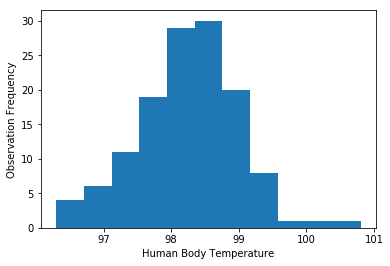

In [8]:
import matplotlib.pyplot as plt
import numpy as np
n_bins = int(np.sqrt(len(df.temperature)))
_ = plt.hist(df.temperature, bins=n_bins)
_ = plt.title('')
_ = plt.xlabel('Human Body Temperature')
_ = plt.ylabel('Observation Frequency')
plt.show()

In [9]:
# Define Empirical Cumulative Distribution Function (ECDF) to compare multiple distributions
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [82]:
# Determine mean and standard deviation from the sample data to model against 
# theoretical values obtained from sampling the normal distribution
df_mean = np.mean(df.temperature)
df_std = np.std(df.temperature)
theory = np.random.normal(df_mean, df_std, size = 10000)

df_x, df_y = ecdf(df.temperature)
theory_x, theory_y = ecdf(theory)

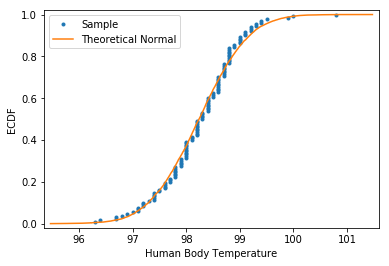

In [83]:
# Plotting these values to visualize similarities or differences
_ = plt.plot(df_x, df_y, marker='.', linestyle = 'none')
_ = plt.plot(theory_x, theory_y)
_ = plt.xlabel('Human Body Temperature')
_ = plt.ylabel('ECDF')
_ = plt.legend(['Sample', 'Theoretical Normal'])
_ = plt.margins(0.02)
plt.show()

The above graph shows the ECDF for a theoretical normal distribution given the mean and standard deviation from our sample set (represented in orange); the blue dots represents our sample data. As we can see, these are very closely aligned, implying the distribution is normal.

# 2. Is the sample size large? Are the observations independent?

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


Per the info on this dataset, there are 130 non-null observations in this dataset. The general rule is a minimum of 30 observations for a dataset to be considered large enough, therefore this dataset is large. 

Each observation in the dataset is a unique occurence of either a male or female's heart rate and body temperature, so they're independent. 

# 3. Is the true population mean really 98.6 degrees F?
## First, try a bootstrap hypothesis test.

 Our Hypothesis we'll be testing is that the mean body temperature is 98.6 degrees F, therefore
 our null hypothesis is the mean body temperature != 98.6

In [20]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

print(df_mean)

98.24923076923078


In [22]:
# We need to translate our dataset's mean to be that of the hypothesis; 98.6
# We then need to take samples of this translated set to find the percent of the time we would observe our sample's mean
# if the true mean is 98.6
temp_translated = df.temperature - df_mean + 98.6
bs_samples = draw_bs_reps(temp_translated, np.mean, 100000)
p = np.sum(bs_samples <= df_mean) / 100000
print('p = ', p)
print(df_mean)

p =  0.0
98.24923076923078


After 100,000 samples, we obtained a p value of 0.0 meaning that we weren't able to replicate even 1 set that obtained the same mean as our dataset, so we should reject the null hypothesis. The mean body temperature for our sample set is 98.25.


**Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?**

A one sample test is sufficient because we are comparing a sample mean to an assumed / known population mean.

**In this situation, is it appropriate to use the  𝑡  or  𝑧  statistic?**

Because we do not know the general populations standard deviation, the t-statistic should be used. 

In [23]:
from scipy import stats
t_stat, t_pval = stats.ttest_1samp(a=df.temperature, popmean=98.6)
print('The T-Statistic is: ', str(t_stat))
print('with a p-value of: ', str(t_pval))

The T-Statistic is:  -5.4548232923645195
with a p-value of:  2.4106320415561276e-07


Our T-statistic is -5.45, with a very small p value. This means that for us to observe our sample mean of 98.25, we would be 5.45 standard deviations away from the population mean of 98.6. Furthermore, our very small p-value means it's very unlikely to observe the mean of our sample if the true mean were 98.6. 

**Now try using the other test. How is the result be different? Why?**

If our sample size were to increase, the t-test result would converge to the z-test result. 

In [25]:
from statsmodels.stats.weightstats import ztest
z_stat, z_pval = ztest(df.temperature, value = 98.6)
print('The Z-Statistic is: ', str(z_stat))
print('with a p-value of: ', str(z_pval))

The Z-Statistic is:  -5.4548232923645195
with a p-value of:  4.9021570141012155e-08


We observed similar results through the z test, with -5.45 as our z value, but with an even smaller p-value

# 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.
**Which one is the correct one to use?**
**What do you notice? What does this tell you about the difference in application of the  𝑡  and  𝑧  statistic?**

In [41]:
np.random.seed(4)
small_temp = np.random.choice(df.temperature, size=10)
small_t_stat, small_t_pval = stats.ttest_1samp(a=small_temp, popmean=98.6)
small_z_stat, small_z_pval = ztest(small_temp, value=98.6)
print('The T-Statistic is: ', str(small_t_stat))
print('     with a p-value of: ', str(small_t_pval))
print('The Z-Statistic is: ', str(small_z_stat))
print('     with a p-value of: ', str(small_z_pval))

The T-Statistic is:  -1.1677484162422795
     with a p-value of:  0.2729122150940388
The Z-Statistic is:  -1.1677484162422798
     with a p-value of:  0.2429082609043257


Because we are using a random sample of size 10, the t-test is appropriate. 
We observed a T-statistic of -1.16, meaning we're just barely over 1 standard deviation away now, with a high p-value. Meaning we can no longer reject the null hypothesis, and that the chance of observing our mean or lower, give the true mean is 98.6 would happen ~27% of the time. 
A difference observed between the T-statistic and Z-statistic is that it has a slightly lower p-value, meaning there would be a slightly lower chance of observing our mean. 

# 5. At what temperature should we consider someone's temperature to be "abnormal"?
**As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.** 

**Start by computing the margin of error and confidence interval.** 

**When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.** 

In [67]:
df_mean = np.mean(df.temperature)
df_std = np.std(df.temperature)
temp_translated = df.temperature - df_mean + 98.6
bs_samples = draw_bs_reps(temp_translated, np.mean, 100000)
bs_mean = np.mean(bs_samples)
p = np.sum(bs_samples <= df_mean) / len(bs_samples)
print('p = ', p)
print('DF mean: ', str(df_mean))
print('Bootstrap sample mean: ', str(bs_mean))

p =  0.0
DF mean:  98.24923076923078 Bootstrap sample mean:  98.6003001230769


In [69]:
standard_error = df_std / np.sqrt(len(df.temperature))
print('The standard margin of error: ', str(standard_error))

confi_int = np.percentile(bs_samples, [2.5, 97.5])
print('Our confidence interval is: ', confi_int)

The standard margin of error:  0.06405661469519336
Our confidence interval is:  [98.47538462 98.72615385]


# 6. Is there a significant difference between males and females in normal temperature?


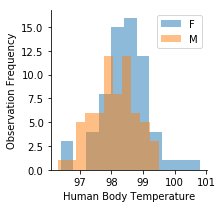

Number of females in dataset:  65
Number of males in dataset:  65


In [81]:
import seaborn as sns

females = df[df.gender=='F']
males = df[df.gender=='M']

n_bins = int(np.sqrt(len(df.temperature)))
_ = sns.FacetGrid(df, hue = 'gender', legend_out=True)
_.map(plt.hist, 'temperature', bins=n_bins, alpha=0.5)
_ = plt.title('')
_ = plt.xlabel('Human Body Temperature')
_ = plt.ylabel('Observation Frequency')
plt.legend(loc=1)
plt.show()
print('Number of females in dataset: ', str(len(females.temperature)))
print('Number of males in dataset: ', str(len(males.temperature)))

From this dataset, it appears females may have a slightly higher average body temperature, and less variability. Though this is hard to confirm. 

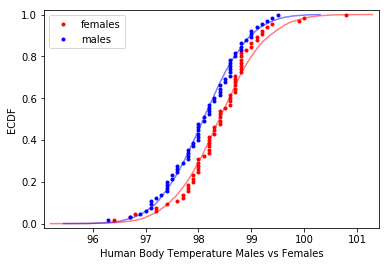

In [90]:
female_mean = np.mean(females.temperature)
female_std = np.std(females.temperature)
female_theory = np.random.normal(female_mean, female_std, size = 10000)

male_mean = np.mean(males.temperature)
male_std = np.std(males.temperature)
male_theory = np.random.normal(male_mean, male_std, size = 10000)

female_x, female_y = ecdf(females.temperature)
theory_f_x, theory_f_y = ecdf(female_theory)
male_x, male_y = ecdf(males.temperature)
theory_m_x, theory_m_y = ecdf(male_theory)

_ = plt.plot(female_x, female_y, marker='.', linestyle = 'none', color='r')
_ = plt.plot(male_x, male_y, marker='.', linestyle = 'none', color='b')
_ = plt.plot(theory_f_x, theory_f_y, color='r', alpha=0.5)
_ = plt.plot(theory_m_x, theory_m_y, color='b', alpha=0.5)
_ = plt.xlabel('Human Body Temperature Males vs Females')
_ = plt.ylabel('ECDF')
_ = plt.legend(('females', 'males'))
_ = plt.margins(0.02)
plt.show()

Our null hypothesis will  now be the average temperature of female = average temperature of male

In [95]:
female_var = np.var(females.temperature)
male_var = np.var(males.temperature)
print('female average : ', str(female_mean))
print('       variance: ', str(female_var))
print('       std     : ', str(female_std))
print('male average : ', str(male_mean))
print('     variance: ', str(male_var))
print('     std     : ', str(male_std))

female average :  98.39384615384613
       variance:  0.5442698224852062
       std     :  0.7377464486428966
male average :  98.1046153846154
     variance:  0.4807479289940825
     std     :  0.6933598841828696


In [94]:
gender_tstat, gender_pval = stats.ttest_ind(a = females.temperature, b = males.temperature, equal_var=False)
print('Our T-statistic: ', str(gender_tstat))
print('Our p-value: ', str(gender_pval))

Our T-statistic:  2.285434538165611
Our p-value:  0.023938264182934196


**What testing approach did you use and why?** 
I used the t-test assuming both datasets had the same average. I used this because we were asked if there was a significant difference between normal male and female temperatures. 

Since they are over 2 standard deviations away from each other, with a p-val < 0.05 we can reject the null hypothesis that their averages are the same, therefore determining that there is a significant difference between normal male and female temperatures. 


**Write a story with your conclusion in the context of the original problem.**

Base on the given dataset, the mean human body temperature has been proven to be 98.25, rather than 98.6 degrees F. 

Our dataset had 130 observations, 65 from males and 65 from females. The original dataset, as well as the 2 subset datasets we created were approximately normal

In our test to determine whether there was significant differences between male and female temperature, we saw that there were in fact. From our test, we saw that women have a slightly higher average body temperature, with more variability. 

Had we gone back to the original problem, and determined if the average male body temperature was 98.6, we probably would have found that it's even more unlikely (due to the smaller average or 98.1), however if we checked if the average female body temperature were 98.6, it would have been more likely (than the entire population), due to the higher average female temperature of 98.4.

